In [1]:
import re
from glob import iglob
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from hurry.filesize import size
import seaborn as sns
import math


def split_on_slash(df_col, split_index):
    return df_col.apply(lambda x: x.split(" / ")[split_index])


def get_only_characters(string):
    return re.sub(r"[^a-zA-Z]+", "", string)


def get_only_numbers(string):
    return float(re.sub(r"[^\d\.]", "", string))


def to_bit(value):
    return int(
        {
            "b": get_only_numbers(value) * 1,
            "kib": get_only_numbers(value) * 10e3,
            "kb": get_only_numbers(value) * 10e3,
            "mib": get_only_numbers(value) * 10e6,
            "mb": get_only_numbers(value) * 10e6,
            "gib": get_only_numbers(value) * 10e9,
            "gb": get_only_numbers(value) * 10e9,
        }.get(get_only_characters(value).lower(), 0)
    )


def percentage_to_float(df_col):
    return df_col.apply(lambda x: float(x[0:-1]))

In [2]:
dfs = {}
for fname in iglob("*.csv"):
    if fname in ("logs_200.csv", "logs_300.csv", "logs_500.csv"):
        continue

    df = pd.read_csv(fname, delimiter=r"\s\s+", engine="python")

    df = df[df["NET I/O"] != "NET I/O"]

    df["mem_percentage"] = percentage_to_float(df["MEM %"])
    df["cpu_percentage"] = percentage_to_float(df["CPU %"])
    df["mem_usage_bits"] = df["MEM USAGE / LIMIT"].apply(lambda x: to_bit(x[: x.find("/") - 1]))
    df[["net_input_bits", "net_output_bits"]] = df["NET I/O"].apply(
        lambda x: pd.Series(map(to_bit, map(str.strip, x.split("/"))))
    )
    df = df.drop(["CONTAINER ID", "CPU %", "MEM USAGE / LIMIT", "MEM %", "NET I/O", "PIDS", "BLOCK I/O"], axis=1)
    # groups = df.groupby('NAME')
    dfs[int(fname[5 : fname.find(".")])] = df

In [52]:
def plot_axis(ax, xlim: tuple, ylim: tuple, fmt, idx, data: tuple, labels: list = None):
    ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    if fmt:
        ax.yaxis.set_major_formatter(fmt)
    if labels:
        for _data, _ in zip(data, labels):
            ax.plot(idx, _data, linewidth=3)

        ax.legend(labels)
    else:
        ax.plot(idx, *data, linewidth=3)


def closest_power_of_2(n):
    return 2 ** math.ceil(math.log(n, 2))

In [92]:
containers = ["edge_data_manager", "edge_broker", "case2-mongodb-1"]
container_nice_names = ["Data Manager", "Edge Broker", "MongoDB"]

max_val_mem = max(max(df.loc[df["NAME"].isin(containers)].mem_percentage) for df in dfs.values())
max_val_cpu = max(max(df.loc[df["NAME"].isin(containers)].cpu_percentage) for df in dfs.values())
max_val_net = max(
    max(
        max(df.loc[df["NAME"].isin(containers)].net_input_bits),
        max(df.loc[df["NAME"].isin(containers)].net_output_bits),
    )
    for df in dfs.values()
)

plt.style.use('ggplot')

In [13]:
sorted(dfs.keys())

[1, 5, 10, 20, 50, 100]

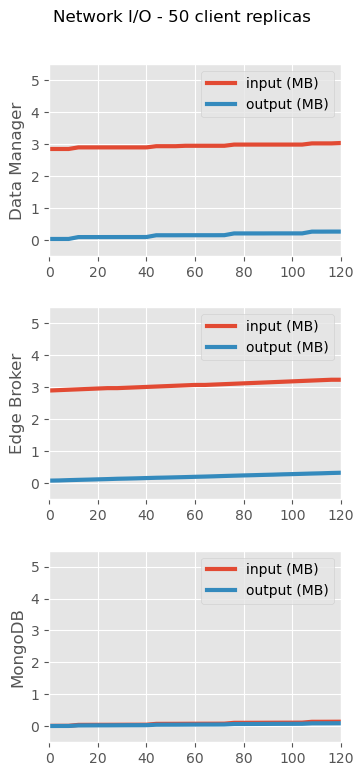

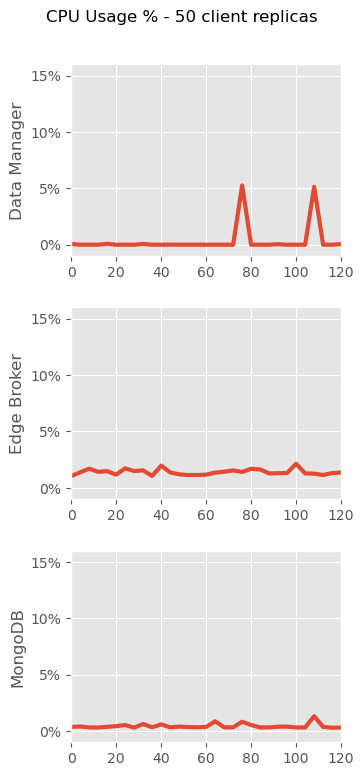

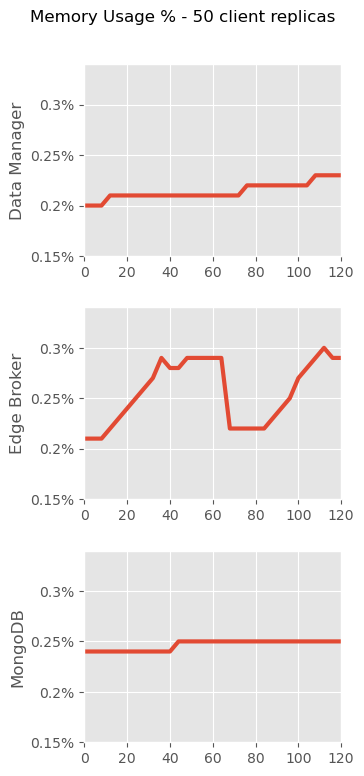

In [91]:
desired_replica = 50

fig_net, axes_net = plt.subplots(nrows=len(containers), ncols=1, figsize=(4, 8))
fig_cpu, axes_cpu = plt.subplots(nrows=len(containers), ncols=1, figsize=(4, 8))
fig_mem, axes_mem = plt.subplots(nrows=len(containers), ncols=1, figsize=(4, 8))

mem_formatter = lambda x, _: f"{int(x*100)/100}%"
cpu_formatter = lambda x, _: f"{int(x)}%"

for i, container in enumerate(containers):
    df = dfs[desired_replica]

    edm = df.loc[df["NAME"] == container].copy()
    edm["time"] = pd.timedelta_range(start="0 seconds", periods=len(edm), freq=f"{round(125 / len(edm))}S")
    edm.set_index("time", inplace=True)
    edm = edm.drop(["NAME"], axis=1)

    plot_axis(
        axes_mem[i],
        (0, 120),
        # (-0.05, closest_power_of_2(max_val_mem)),
        (0.15, max_val_mem),
        # None,
        mem_formatter,
        edm.index.seconds,
        (edm.mem_percentage,),
    )
    plot_axis(axes_cpu[i], (0, 120), (-1, 16), cpu_formatter, edm.index.seconds, (edm.cpu_percentage,))
    plot_axis(
        axes_net[i],
        (0, 120),
        (-0.5, 5.5),
        None,
        edm.index.seconds,
        (edm.net_input_bits.apply(lambda x: x / (8e6)), edm.net_output_bits.apply(lambda x: x / (8e6))),
        ["input (MB)", "output (MB)"],
    )

for axes in [axes_mem, axes_cpu, axes_net]:
    for ax, row in zip(axes, container_nice_names):
        ax.set_ylabel(row, rotation=90, size="large")
        ax.grid(visible=True)

basepath = f'img/{desired_replica}'
os.makedirs(f'{basepath}/svg', exist_ok=True)
os.makedirs(f'{basepath}/png', exist_ok=True)

fig_cpu.suptitle(f"CPU Usage % - {desired_replica} client replicas")
fig_mem.suptitle(f"Memory Usage % - {desired_replica} client replicas")
fig_net.suptitle(f"Network I/O - {desired_replica} client replicas")
fig_cpu.tight_layout(pad=2)
fig_mem.tight_layout(pad=2)
fig_net.tight_layout(pad=2)

path = f'{basepath}/svg/'
fig_cpu.savefig(fname=path + "fig_cpu.svg")
fig_mem.savefig(fname=path + "fig_mem.svg")
fig_net.savefig(fname=path + "fig_net_io.svg")

path = f'{basepath}/png/'
fig_cpu.savefig(fname=path + "fig_cpu.png")
fig_mem.savefig(fname=path + "fig_mem.png")
fig_net.savefig(fname=path + "fig_net_io.png")

plt.show()

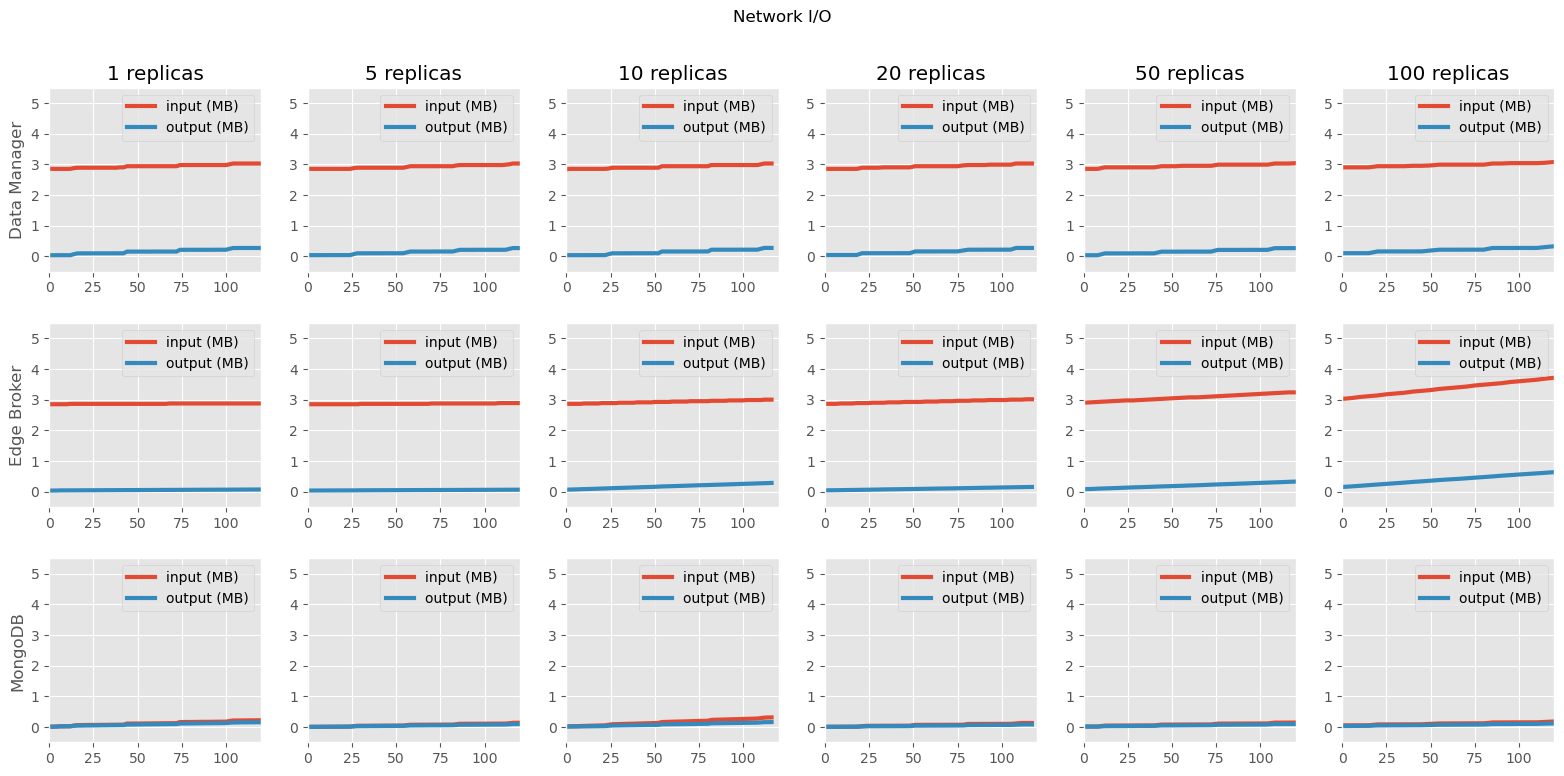

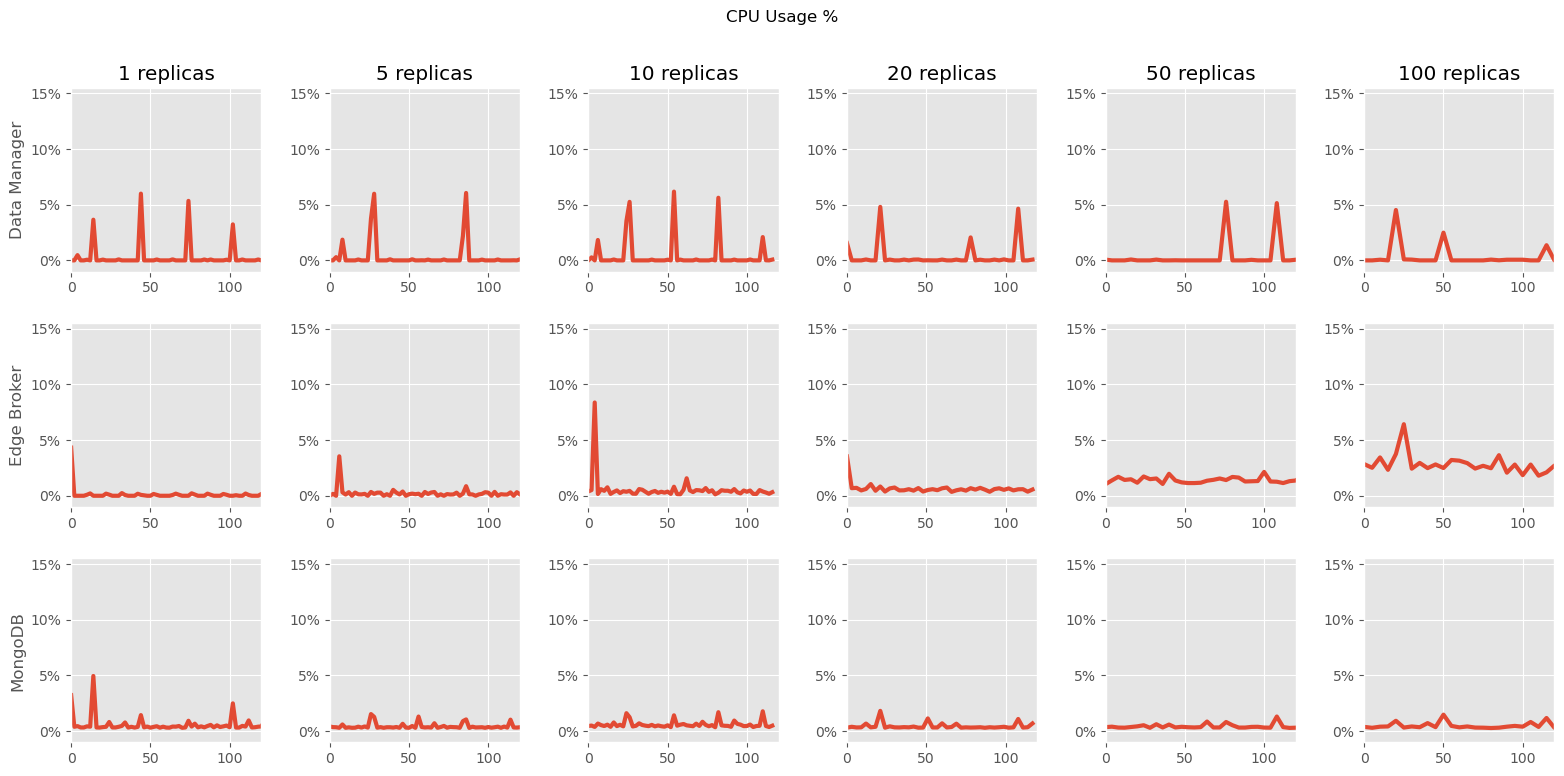

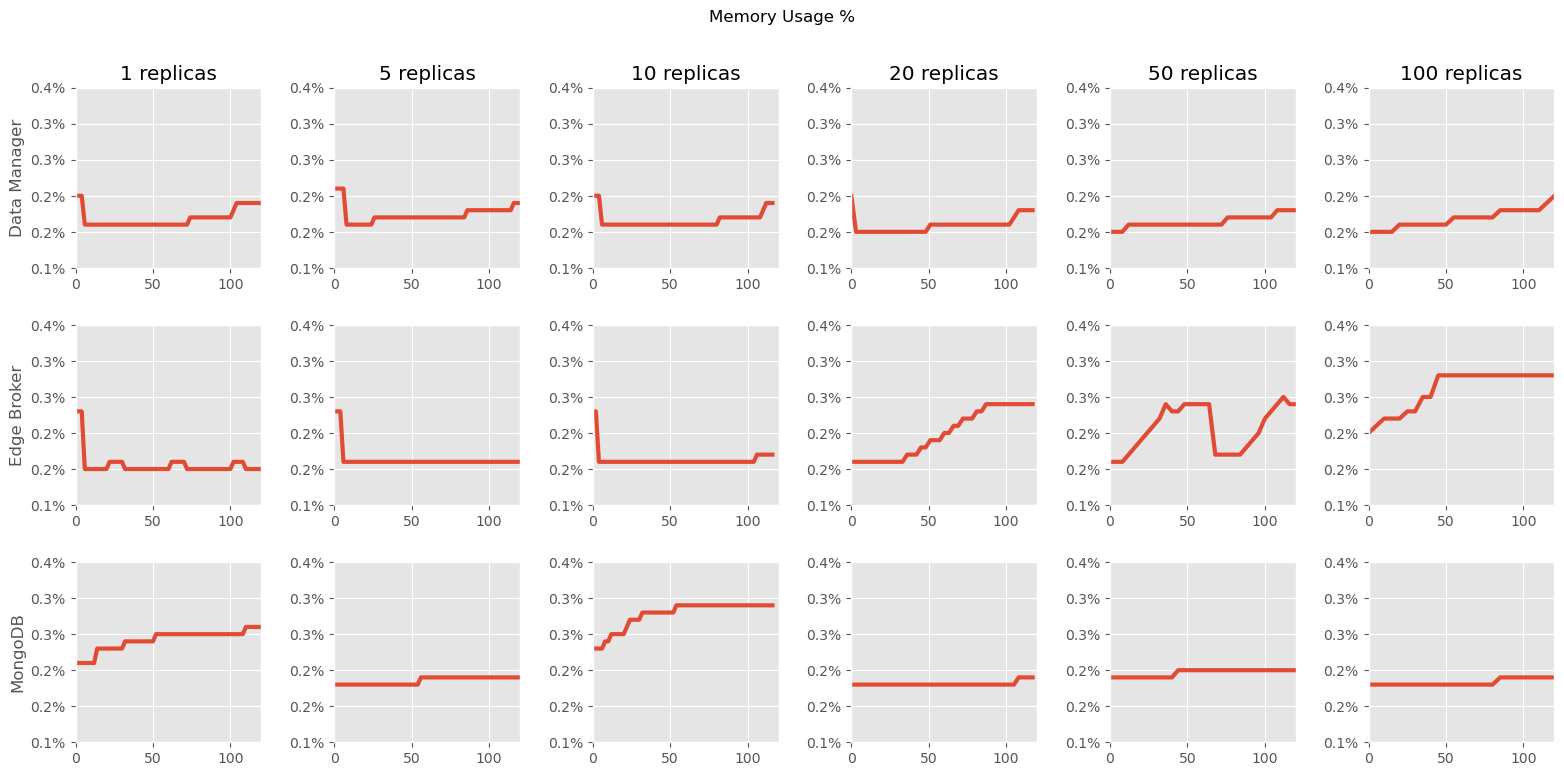

In [111]:
fig_net, axes_net = plt.subplots(nrows=len(containers), ncols=len(dfs), figsize=(16, 8))
fig_cpu, axes_cpu = plt.subplots(nrows=len(containers), ncols=len(dfs), figsize=(16, 8))
fig_mem, axes_mem = plt.subplots(nrows=len(containers), ncols=len(dfs), figsize=(16, 8))

for i, container in enumerate(containers):
    for j, replicas_amount in enumerate(sorted(dfs.keys())):
        df = dfs[replicas_amount]

        edm = df.loc[df["NAME"] == container].copy()
        edm['time'] = pd.timedelta_range(start='0 seconds', periods=len(edm), freq=f'{round(125 / len(edm))}S')
        edm.set_index("time", inplace=True)
        edm = edm.drop(["NAME"], axis=1)

        plot_axis(axes_mem[i][j], (0, 120), (0.15, 0.4), (lambda x, _: f'{int(x*10)/10}%'), edm.index.seconds, (edm.mem_percentage,))
        plot_axis(axes_cpu[i][j], (0, 120), (-1, 15.5), (lambda x, _: f'{int(x)}%'), edm.index.seconds, (edm.cpu_percentage,))
        plot_axis(axes_net[i][j], (0, 120), (-0.5, 5.5), None, edm.index.seconds, (edm.net_input_bits.apply(lambda x: x / (8e6)), edm.net_output_bits.apply(lambda x: x / (8e6))), ['input (MB)', 'output (MB)'])

for axes in [axes_mem, axes_cpu, axes_net]:
    for ax, col in zip(axes[0], sorted(dfs.keys())):
        ax.set_title(f'{col} replicas')

    for ax, row in zip(axes[:, 0], container_nice_names):
        ax.set_ylabel(row, rotation=90, size='large')

basepath = f'img/all'
os.makedirs(f'{basepath}/svg', exist_ok=True)
os.makedirs(f'{basepath}/png', exist_ok=True)

fig_cpu.suptitle("CPU Usage %")
fig_mem.suptitle("Memory Usage %")
fig_net.suptitle("Network I/O")
fig_cpu.tight_layout(pad=2)
fig_mem.tight_layout(pad=2)
fig_net.tight_layout(pad=2)

path = f'{basepath}/svg/'
fig_cpu.savefig(fname=path + "fig_cpu.svg")
fig_mem.savefig(fname=path + "fig_mem.svg")
fig_net.savefig(fname=path + "fig_net_io.svg")

path = f'{basepath}/png/'
fig_cpu.savefig(fname=path + "fig_cpu.png")
fig_mem.savefig(fname=path + "fig_mem.png")
fig_net.savefig(fname=path + "fig_net_io.png")

plt.show()